In [1]:
pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import cv2
import mediapipe as mp

In [3]:
#holistic model. process, import from otehr file
# Copyright 2020-2021 The MediaPipe Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""MediaPipe Holistic."""

from typing import NamedTuple

import numpy as np

# The following imports are needed because python pb2 silently discards
# unknown protobuf fields.
# pylint: disable=unused-import
from mediapipe.calculators.core import constant_side_packet_calculator_pb2
from mediapipe.calculators.core import gate_calculator_pb2
from mediapipe.calculators.core import split_vector_calculator_pb2
from mediapipe.calculators.tensor import image_to_tensor_calculator_pb2
from mediapipe.calculators.tensor import inference_calculator_pb2
from mediapipe.calculators.tensor import tensors_to_classification_calculator_pb2
from mediapipe.calculators.tensor import tensors_to_floats_calculator_pb2
from mediapipe.calculators.tensor import tensors_to_landmarks_calculator_pb2
from mediapipe.calculators.tflite import ssd_anchors_calculator_pb2
from mediapipe.calculators.util import detections_to_rects_calculator_pb2
from mediapipe.calculators.util import landmark_projection_calculator_pb2
from mediapipe.calculators.util import local_file_contents_calculator_pb2
from mediapipe.calculators.util import non_max_suppression_calculator_pb2
from mediapipe.calculators.util import rect_transformation_calculator_pb2
from mediapipe.framework.tool import switch_container_pb2
from mediapipe.modules.holistic_landmark.calculators import roi_tracking_calculator_pb2
# pylint: enable=unused-import

from mediapipe.python.solution_base import SolutionBase
from mediapipe.python.solutions import download_utils
# pylint: disable=unused-import
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_CONTOURS
from mediapipe.python.solutions.face_mesh_connections import FACEMESH_TESSELATION
from mediapipe.python.solutions.hands import HandLandmark
from mediapipe.python.solutions.hands_connections import HAND_CONNECTIONS
from mediapipe.python.solutions.pose import PoseLandmark
from mediapipe.python.solutions.pose_connections import POSE_CONNECTIONS
# pylint: enable=unused-import

_BINARYPB_FILE_PATH = 'mediapipe/modules/holistic_landmark/holistic_landmark_cpu.binarypb'


def _download_oss_pose_landmark_model(model_complexity):
  """Downloads the pose landmark lite/heavy model from the MediaPipe Github repo if it doesn't exist in the package."""

  if model_complexity == 0:
    download_utils.download_oss_model(
        'mediapipe/modules/pose_landmark/pose_landmark_lite.tflite')
  elif model_complexity == 2:
    download_utils.download_oss_model(
        'mediapipe/modules/pose_landmark/pose_landmark_heavy.tflite')


class Holistic(SolutionBase):
  """MediaPipe Holistic.

  MediaPipe Holistic processes an RGB image and returns pose landmarks, left and
  right hand landmarks, and face mesh landmarks on the most prominent person
  detected.

  Please refer to https://solutions.mediapipe.dev/holistic#python-solution-api
  for usage examples.
  """

  def __init__(self,
               static_image_mode=False,
               model_complexity=1,
               smooth_landmarks=True,
               enable_segmentation=False,
               smooth_segmentation=True,
               refine_face_landmarks=False,
               min_detection_confidence=0.5,
               min_tracking_confidence=0.5):
    """Initializes a MediaPipe Holistic object.

    Args:
      static_image_mode: Whether to treat the input images as a batch of static
        and possibly unrelated images, or a video stream. See details in
        https://solutions.mediapipe.dev/holistic#static_image_mode.
      model_complexity: Complexity of the pose landmark model: 0, 1 or 2. See
        details in https://solutions.mediapipe.dev/holistic#model_complexity.
      smooth_landmarks: Whether to filter landmarks across different input
        images to reduce jitter. See details in
        https://solutions.mediapipe.dev/holistic#smooth_landmarks.
      enable_segmentation: Whether to predict segmentation mask. See details in
        https://solutions.mediapipe.dev/holistic#enable_segmentation.
      smooth_segmentation: Whether to filter segmentation across different input
        images to reduce jitter. See details in
        https://solutions.mediapipe.dev/holistic#smooth_segmentation.
      refine_face_landmarks: Whether to further refine the landmark coordinates
        around the eyes and lips, and output additional landmarks around the
        irises. Default to False. See details in
        https://solutions.mediapipe.dev/holistic#refine_face_landmarks.
      min_detection_confidence: Minimum confidence value ([0.0, 1.0]) for person
        detection to be considered successful. See details in
        https://solutions.mediapipe.dev/holistic#min_detection_confidence.
      min_tracking_confidence: Minimum confidence value ([0.0, 1.0]) for the
        pose landmarks to be considered tracked successfully. See details in
        https://solutions.mediapipe.dev/holistic#min_tracking_confidence.
    """
    _download_oss_pose_landmark_model(model_complexity)
    super().__init__(
        binary_graph_path=_BINARYPB_FILE_PATH,
        side_inputs={
            'model_complexity': model_complexity,
            'smooth_landmarks': smooth_landmarks and not static_image_mode,
            'enable_segmentation': enable_segmentation,
            'smooth_segmentation':
                smooth_segmentation and not static_image_mode,
            'refine_face_landmarks': refine_face_landmarks,
            'use_prev_landmarks': not static_image_mode,
        },
        calculator_params={
            'poselandmarkcpu__posedetectioncpu__TensorsToDetectionsCalculator.min_score_thresh':
                min_detection_confidence,
            'poselandmarkcpu__poselandmarkbyroicpu__tensorstoposelandmarksandsegmentation__ThresholdingCalculator.threshold':
                min_tracking_confidence,
        },
        outputs=[
            'pose_landmarks', 'pose_world_landmarks', 'left_hand_landmarks',
            'right_hand_landmarks', 'face_landmarks', 'segmentation_mask'
        ])

  def process(self, image: np.ndarray) -> NamedTuple:
    """Processes an RGB image and returns the pose landmarks, left and right hand landmarks, and face landmarks on the most prominent person detected.

    Args:
      image: An RGB image represented as a numpy ndarray.

    Raises:
      RuntimeError: If the underlying graph throws any error.
      ValueError: If the input image is not three channel RGB.

    Returns:
      A NamedTuple with fields describing the landmarks on the most prominate
      person detected:
        1) "pose_landmarks" field that contains the pose landmarks.
        2) "pose_world_landmarks" field that contains the pose landmarks in
        real-world 3D coordinates that are in meters with the origin at the
        center between hips.
        3) "left_hand_landmarks" field that contains the left-hand landmarks.
        4) "right_hand_landmarks" field that contains the right-hand landmarks.
        5) "face_landmarks" field that contains the face landmarks.
        6) "segmentation_mask" field that contains the segmentation mask if
           "enable_segmentation" is set to true.
    """

    results = super().process(input_data={'image': image})
    if results.pose_landmarks:  # pytype: disable=attribute-error
      for landmark in results.pose_landmarks.landmark:  # pytype: disable=attribute-error
        landmark.ClearField('presence')
    if results.pose_world_landmarks:  # pytype: disable=attribute-error
      for landmark in results.pose_world_landmarks.landmark:  # pytype: disable=attribute-error
        landmark.ClearField('presence')
    return results

In [4]:
#Extract Landmarks
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    # results = model.process(image)
    h=Holistic()
    results = h.process(image=image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [5]:
#Draw Landmarks
def draw_landmarks(image, results):
    mp_holistic = mp.solutions.holistic  # Holistic model
    mp_drawing = mp.solutions.drawing_utils  # Drawing utilities
    # Draw left hand connections
    image = mp_drawing.draw_landmarks(
            image,
            landmark_list=results.left_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(
                color=(232, 254, 255), thickness=1, circle_radius=4
            ),
            connection_drawing_spec=mp_drawing.DrawingSpec(
                color=(255, 249, 161), thickness=2, circle_radius=2
            ),
    )
    # Draw right hand connections
    image = mp_drawing.draw_landmarks(
            image,
            landmark_list=results.right_hand_landmarks,
            connections=mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(
                color=(232, 254, 255), thickness=1, circle_radius=4
            ),
            connection_drawing_spec=mp_drawing.DrawingSpec(
                color=(255, 249, 161), thickness=2, circle_radius=2
            ),
    )
    return image

In [6]:
#Hand Model
from typing import List

import numpy as np
import mediapipe as mp

class HandModel(object):
    """
    Params
        landmarks: List of positions
    Args
        connections: List of tuples containing the ids of the two landmarks representing a connection
        feature_vector: list of length 21*21=441 containing the angles between all connections
    """
    def __init__(self, landmarks: List[float]):
        self.connections = mp.solutions.holistic.HAND_CONNECTIONS

        landmarks = np.array(landmarks).reshape((21, 3))
        self.feature_vector = self._get_feature_vector(landmarks)

    def _get_feature_vector(self, landmarks: np.ndarray) -> List[float]:
        """
        Params
            landmarks: numpy array of shape (21, 3)
        Return
            List of length nb_connections * nb_connections containing all the angles between the connections
        """
        connections = self._get_connections_from_landmarks(landmarks)

        angles_list = []
        for connection_from in connections:
            for connection_to in connections:
                angle = self._get_angle_between_vectors(connection_from, connection_to)
                # If the angle is not null we store it else we store 0
                if angle == angle:
                    angles_list.append(angle)
                else:
                    angles_list.append(0)
        return angles_list

    def _get_connections_from_landmarks(self, landmarks: np.ndarray) -> List[np.ndarray]:
        """
        Params
            landmarks: numpy array of shape (21, 3)
        Return
            List of vectors representing hand connections
        """
        return list(
            map(
                lambda t: landmarks[t[1]] - landmarks[t[0]],
                self.connections,
            )
        )

    @staticmethod
    def _get_angle_between_vectors(u: np.ndarray, v: np.ndarray) -> float:
        """
        Params
            u, v: 3D vectors representing two connections
        Return
            Angle between the two vectors
        """
        dot_product = np.dot(u, v)
        norm = np.linalg.norm(u) * np.linalg.norm(v)
        return np.arccos(dot_product / norm)

In [7]:
#Sign Model
# import doqu
# from doqu import document_base
from typing import List

import numpy as np


class SignModel(object):
    def __init__(
        self, left_hand_list: List[List[float]], right_hand_list: List[List[float]]
    ):
        """
        Params
            x_hand_list: List of all landmarks for each frame of a video
        Args
            has_x_hand: bool; True if x hand is detected in the video, otherwise False
            xh_embedding: ndarray; Array of shape (n_frame, nb_connections * nb_connections)
        """
        self.has_left_hand = np.sum(left_hand_list) != 0
        self.has_right_hand = np.sum(right_hand_list) != 0

        self.lh_embedding = self._get_embedding_from_landmark_list(left_hand_list)
        self.rh_embedding = self._get_embedding_from_landmark_list(right_hand_list)

    @staticmethod
    def _get_embedding_from_landmark_list(hand_list: List[List[float]]) -> List[List[float]]:
        """
        Params
            hand_list: Array of shape (n_frame, nb_landmarks * 3) containing
                       the 3D coordinates of all landmarks for each frame
        Return
            embedding: Array of shape (n_frame, nb_connections * nb_connections) containing
                       the feature_vectors of the hand for each frame
        """
        embedding = []
        for frame_idx in range(len(hand_list)):
            if np.sum(hand_list[frame_idx]) == 0:
                continue

            hand_gesture = HandModel(hand_list[frame_idx])
            embedding.append(hand_gesture.feature_vector)
        return embedding

In [8]:
pip install fastdtw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
#Sign Prediction
import pandas as pd
from fastdtw import fastdtw
import numpy as np


def dtw_distances(recorded_sign: SignModel, reference_signs: pd.DataFrame):
    """
    Use DTW to compute similarity between the recorded sign & the reference signs
    :param recorded_sign: a SignModel object containing the data gathered during record
    :param reference_signs: pd.DataFrame
                            columns : name, dtype: str
                                      sign_model, dtype: SignModel
                                      distance, dtype: float64
    :return: Return a sign dictionary sorted by the distances from the recorded sign
    """
    # Embeddings of the recorded sign
    rec_left_hand = recorded_sign.lh_embedding
    rec_right_hand = recorded_sign.rh_embedding

    for idx, row in reference_signs.iterrows():
        # Initialize the row variables
        ref_sign_name, ref_sign_model, _ = row

        # If the reference sign has the same number of hands compute fastdtw
        if (recorded_sign.has_left_hand == ref_sign_model.has_left_hand) and (
            recorded_sign.has_right_hand == ref_sign_model.has_right_hand
        ):
            ref_left_hand = ref_sign_model.lh_embedding
            ref_right_hand = ref_sign_model.rh_embedding

            if recorded_sign.has_left_hand:
                row["distance"] += list(fastdtw(rec_left_hand, ref_left_hand))[0]
            if recorded_sign.has_right_hand:
                row["distance"] += list(fastdtw(rec_right_hand, ref_right_hand))[0]

        # If not, distance equals infinity
        else:
            row["distance"] = np.inf
    return reference_signs.sort_values(by=["distance"])


In [10]:
def _get_sign_predicted(self, batch_size=5, threshold=0.5):
    # Get the list (of size batch_size) of the most similar reference signs
    sign_names = self.sign_dictionary.iloc[:batch_size]["name"].values

    # Count the occurrences of each sign and sort them by ascending order
    sign_counter = Counter(sign_names).most_common()

    # Check if the most similar sign's proportion in the batch is greater than the threshold
    predicted_sign, count = sign_counter[0]
    if count / batch_size < threshold:
        return "Signe inconnu"
    return predicted_sign

In [15]:
from PIL import Image
import numpy as np
im = Image.open("/content/f15.jpeg")
p = np.array(im)

In [16]:
type(im)

PIL.JpegImagePlugin.JpegImageFile

In [30]:
# read_img = cv2.imread("/content/sample_data/frame_15.jpg")
imagepath="/content/f15.jpeg"
image= cv2.imread(imagepath,cv2.IMREAD_ANYDEPTH |cv2.IMREAD_UNCHANGED)
image, results = mediapipe_detection(model=HandModel, image=image)

In [31]:
print(image.shape[2])

3


In [ ]:
landmark_image = draw_landmarks(image, results)

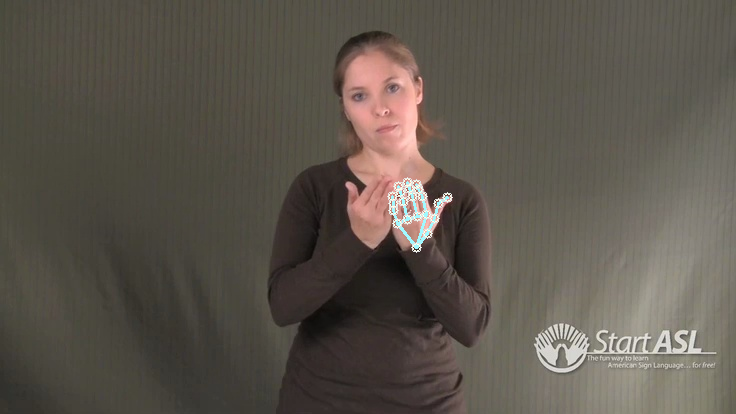

In [29]:
from google.colab.patches import cv2_imshow
cv2_imshow(image)